In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as spio
import torch
import math
import time
import timeit

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset, zoomed_inset_axes)

from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches


from matplotlib.backends.backend_pdf import PdfPages


# from tensorflow import keras
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout
#from keras.layers.recurrent import LSTM
#from keras.layers import TimeDistributed, Conv1D
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import concatenate
#from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Conv1D, concatenate
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model



from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


2025-06-08 12:50:12.524798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-08 12:50:12.605182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-08 12:50:12.605196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-08 12:50:12.628075: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 12:50:13.154707: W tensorflow/stream_executor/platform/de

In [2]:
co_p = 1
co_f = 1
magic_number = 0.005

# TEE_Zero

In [3]:
import scipy.io as spio
import numpy as np
from scipy.spatial.transform import Rotation as R

matx = spio.loadmat('TEE_zero_cellformat_Final.mat', squeeze_me=True)
#start, end = 3005, 16915
start, end = 5000, 19000

# —————————————————————————————————————————————————————————————
# FIRST SUB-DATASET (zero) NORMALIZATION
raw_pose_zero      = matx['posecell'][start: end]     # (N,7)
pos_zero           = raw_pose_zero[:, :3]             # (N,3)
quat_zero          = raw_pose_zero[:, 3:]             # (N,4)

rot                = R.from_euler('xyz', [0, -20, 40], degrees=True)
pos_rot_zero       = rot.apply(pos_zero)
quat_rot_zero      = (rot * R.from_quat(quat_zero)).as_quat()

pose_rotated_zero  = np.hstack([pos_rot_zero, quat_rot_zero])  # (N,7)

# compute this split’s mean & std
pose_mean_zero     = pose_rotated_zero.mean(axis=0)           # (7,)
#print("this is mean",pose_mean_zero)
pose_std_zero      = pose_rotated_zero.std(axis=0)            # (7,)
pose_std_zero[pose_std_zero == 0] = 1.0                       # avoid div-by-zero

# normalize
pose_norm_zero     = (pose_rotated_zero - pose_mean_zero) / pose_std_zero

# apply co_p scaling
multi_data_1 = co_p * pose_norm_zero                  # (N,7)

print("zero-split normalized+scaled pose[0]:", multi_data_1[0])
print("zero-split pose_norm shape:",          multi_data_1.shape)

# —————————————————————————————————————————————————————————————
# MOTOR PART for zero split
motor_zero_raw     = matx['motorcell'][start:end]             # (N, M)
multi_data_f_1  = motor_zero_raw * magic_number

print("zero-split motor[0]:", multi_data_f_1[11000])
print("zero-split motor shape:", multi_data_f_1.shape)




zero-split normalized+scaled pose[0]: [ 0.59962935  0.73353566  1.56386406 -2.18058366  0.51414549 -1.05626838
 -2.28287685]
zero-split pose_norm shape: (14000, 7)
zero-split motor[0]: [-0.00016874 -0.00381961  0.00610803 -0.00880505]
zero-split motor shape: (14000, 4)


# TEE_45

In [4]:
import scipy.io as spio
import numpy as np
from scipy.spatial.transform import Rotation as R

matx_45    = spio.loadmat('TEE_45_cellformat_Final.mat', squeeze_me=True)
start_45, end_45 = 0, 14000

# 1) grab raw pose [x,y,z,qx,qy,qz,qw]
raw_pose_45    = matx_45['posecell'][start_45:end_45]       # (N,7)
pos_45         = raw_pose_45[:, :3]                         # (N,3)
quat_45        = raw_pose_45[:, 3:]                         # (N,4)

# 2) define the rotation R_eul = Rz(40°)·Ry(-15°)·Rx(0°)
rot_45         = R.from_euler('xyz', [0, -20, 40], degrees=True)

# 3a) rotate positions
pos_rot_45     = rot_45.apply(pos_45)

# 3b) rotate orientations: new_q = R * old_q
quat_rot_45    = (rot_45 * R.from_quat(quat_45)).as_quat()

# 4) recombine (unscaled)
pose_rotated_45 = np.hstack([pos_rot_45, quat_rot_45])      # (N,7)

# 5) compute this split’s mean & std
pose_mean_45   = pose_rotated_45.mean(axis=0)               # (7,)
pose_std_45    = pose_rotated_45.std(axis=0)                # (7,)
pose_std_45[pose_std_45 == 0] = 1.0                         # avoid div-by-zero

# 6) normalize zero-mean, unit-variance
pose_norm_45   = (pose_rotated_45 - pose_mean_45) / pose_std_45

# 7) apply your co_p scaler on the normalized data
dffx_2         = co_p * pose_norm_45                        # (N,7)
multi_data_2   = dffx_2

print("45-split normalized+scaled pose[0]:", multi_data_2[0])
print("45-split pose_norm shape:",           multi_data_2.shape)

# —————————————————————————————————————————————————————————————

# MOTOR PART (45 split): raw motor × magic 0.065 (no normalization)
data_f_45       = matx_45['motorcell'][start_45:end_45]     # (N, M)
multi_data_f_2  = data_f_45 * magic_number

print("motor[0] 45:",    multi_data_f_2[0])
print("motor shape 45:", multi_data_f_2.shape)




45-split normalized+scaled pose[0]: [ 0.78541713 -0.29527736  0.6323551  -1.74307427  0.22805142 -0.7929663
 -0.57827801]
45-split pose_norm shape: (14000, 7)
motor[0] 45: [ 0.         -0.00381961 -0.0104709   0.00039884]
motor shape 45: (14000, 4)


# TEE_90

In [5]:
import scipy.io as spio
import numpy as np
from scipy.spatial.transform import Rotation as R

matx_90      = spio.loadmat('TEE_90_cellformat_Final.mat', squeeze_me=True)
start_90, end_90 = 2000, 16000

# —————————————————————————————————————————————————————————————
# THIRD SUB-DATASET (90°) NORMALIZATION
# 1) grab raw pose [x,y,z,qx,qy,qz,qw]
raw_pose_90      = matx_90['posecell'][start_90:end_90]       # (N,7)
#raw_pose_90      = matx_90['posecell']       # (N,7)

pos_90           = raw_pose_90[:, :3]                         # (N,3)
quat_90          = raw_pose_90[:, 3:]                         # (N,4)

print("lenght" , len (pos_90))

# 2) same rotation as before
#rot_90           = R.from_euler('xyz', [0, -15, -40], degrees=True)
rot_90           = R.from_euler('xyz', [0, -20, 40], degrees=True)


# 3a) rotate positions
pos_rot_90       = rot_90.apply(pos_90)

# 3b) rotate orientations
quat_rot_90      = (rot_90 * R.from_quat(quat_90)).as_quat()

# 4) recombine (unscaled)
pose_rotated_90  = np.hstack([pos_rot_90, quat_rot_90])       # (N,7)

# 5) compute this split’s mean & std
pose_mean_90     = pose_rotated_90.mean(axis=0)               # (7,)
pose_std_90      = pose_rotated_90.std(axis=0)                # (7,)
pose_std_90[pose_std_90 == 0] = 1.0                           # avoid div‐by‐zero

# 6) normalize zero‐mean, unit‐variance
pose_norm_90     = (pose_rotated_90 - pose_mean_90) / pose_std_90

# 7) apply your co_p scaler on normalized data
multi_data_3 = co_p * pose_norm_90                       # (N,7)

print("90-split normalized+scaled pose[0]:", multi_data_3[0])
print("90-split pose_norm shape:",           multi_data_3.shape)

# —————————————————————————————————————————————————————————————
# MOTOR PART for 90° split (magic × 0.065)
motor_90_raw     = matx_90['motorcell'][start_90:end_90]       # (N, M)
multi_data_f_3   = motor_90_raw * magic_number

print("motor[0] 90:",    multi_data_f_3[0])
print("motor shape 90:", multi_data_f_3.shape)
print ("o1", quat_rot_90[:,0])



lenght 14000
90-split normalized+scaled pose[0]: [-2.22191962  0.59085453  1.62664996 -2.12440151  2.06323122 -0.70793746
  0.10733338]
90-split pose_norm shape: (14000, 7)
motor[0] 90: [ 0.00268447  0.00423379 -0.00872575  0.01267068]
motor shape 90: (14000, 4)
o1 [0.14656972 0.1443111  0.14399394 ... 0.80673608 0.80643996 0.80706567]


# Compute mean and std

In [6]:
database = [[multi_data_1, multi_data_f_1],[multi_data_2, multi_data_f_2],[multi_data_3, multi_data_f_3]]


In [7]:
mean = 0
std = 1

mean_f = 0
std_f = 1

# Data Normalization & Prepration

In [8]:
# === Data Preparation & 60/20/20 Split ===
import math

def data_prep_norm(dataset_x, dataset_f):
    """
    Concatenate & reshape each dataset_x / dataset_f, then compute
    60/20/20 train/val/test split indices.

    Returns:
      multi_data_r  -- full 'x' series, shape (T, D_x)
      multi_data_f  -- full 'f' series, shape (T, D_f)
      train_end     -- index where training ends (60% of T)
      val_end       -- index where validation ends (80% of T)
    """
    # total time‐steps
    totalTS = max(dataset_x.shape)

    # X‐data: concatenate then reshape to (T, features)
    cat_x       = np.concatenate(dataset_x[:])
    multi_data_r = cat_x.reshape(totalTS, -1)

    # F‐data: same
    cat_f       = np.concatenate(dataset_f[:])
    multi_data_f = cat_f.reshape(totalTS, -1)

    # split points
    train_end = math.floor(0.7 * totalTS)
    val_end   = math.floor(0.9 * totalTS)

    return multi_data_r, multi_data_f, train_end, val_end


In [9]:
# === Windowing Function for X → y ===
def multivariate_data(dataset, start_index, end_index, history_size, target_size):
    """
    Build sliding windows from `dataset`:
      - inputs:  `history_size` timesteps ending at i-1
      - output:  value at i+target_size

    Args:
      dataset       array of shape (T, D)
      start_index   where to start (inclusive)
      end_index     where to end (exclusive; None → T - target_size)
      history_size  number of past steps in each input
      target_size   steps-forward for prediction

    Returns:
      data  → array shape (N, history_size, D)
      labels→ array shape (N, D)
    """
    data, labels = [], []
    start = start_index + history_size
    stop  = end_index if end_index is not None else len(dataset) - target_size

    for i in range(start, stop):
        idx = range(i - history_size, i)
        data.append(np.reshape(dataset[idx], (history_size, -1)))
        labels.append(dataset[i + target_size])

    return np.array(data), np.array(labels)


In [10]:
# === Windowing Function for F + X → y ===
def multivariate_data_f(dataset_f, dataset, start_index, end_index, history_size, target_size):
    """
    Like `multivariate_data`, but uses:
      - `dataset_f` for input histories
      - `dataset` for labels.

    Args:
      dataset_f     array (T, D_f) → inputs
      dataset       array (T, D_x) → labels
      start_index, end_index, history_size, target_size  same as above

    Returns:
      data_f → array (N, history_size, D_f)
      labels → array (N, D_x)
    """
    data, labels = [], []
    start = start_index + history_size
    stop  = end_index if end_index is not None else len(dataset) - target_size

    for i in range(start, stop):
        idx = range(i - history_size, i)
        data.append(np.reshape(dataset_f[idx], (history_size, -1)))
        labels.append(dataset[i + target_size])

    return np.array(data), np.array(labels)


# TEE_Zero

In [11]:
# -----------------------------------------------------------------------------
# 3) Build your windows for train / val / test
# -----------------------------------------------------------------------------
history = 20
target  = 0

In [12]:
# --- TEE_Zero: train/val/test splits at 60/20/20% ---

# unpack with both split‐points
multi_data_rn_1, multi_data_fn_1, TRAIN_END_1, VAL_END_1 = \
    data_prep_norm(multi_data_1, multi_data_f_1)

# your history & target settings
multivariate_past_history   = 20
multivariate_past_history_f = 20
multivariate_future_target   = 0

# 1) TRAINING set: [0 : TRAIN_END_1)
x_train_multi_1, y_train_multi_1   = multivariate_data(   multi_data_rn_1,
                                                         0,
                                                         TRAIN_END_1,
                                                         multivariate_past_history,
                                                         multivariate_future_target)
f_train_multi_1, fy_train_multi_1 = multivariate_data_f( multi_data_fn_1,
                                                         multi_data_rn_1,
                                                         0,
                                                         TRAIN_END_1,
                                                         multivariate_past_history_f,
                                                         multivariate_future_target)

# 2) VALIDATION set: [TRAIN_END_1 : VAL_END_1)
x_val_multi_1, y_val_multi_1       = multivariate_data(   multi_data_rn_1,
                                                         TRAIN_END_1,
                                                         VAL_END_1,
                                                         multivariate_past_history,
                                                         multivariate_future_target)
f_val_multi_1, fy_val_multi_1     = multivariate_data_f( multi_data_fn_1,
                                                         multi_data_rn_1,
                                                         TRAIN_END_1,
                                                         VAL_END_1,
                                                         multivariate_past_history_f,
                                                         multivariate_future_target)

# 3) TEST set: [VAL_END_1 : end)
x_test_multi_1, y_test_multi_1     = multivariate_data(   multi_data_rn_1,
                                                         VAL_END_1,
                                                         None,
                                                         multivariate_past_history,
                                                         multivariate_future_target)
f_test_multi_1, fy_test_multi_1   = multivariate_data_f( multi_data_fn_1,
                                                         multi_data_rn_1,
                                                         VAL_END_1,
                                                         None,
                                                         multivariate_past_history_f,
                                                         multivariate_future_target)


# TEE_45

In [13]:
# --- TEE_45: 60/20/20 train/val/test split ---

# 1) get full series + split points
multi_data_rn_2, multi_data_fn_2, TRAIN_END_2, VAL_END_2 = \
    data_prep_norm(multi_data_2, multi_data_f_2)

# 2) windowing parameters
multivariate_past_history   = 20
multivariate_past_history_f = 20
multivariate_future_target   = 0

# 3) TRAINING set: [0 : TRAIN_END_2)
x_train_multi_2, y_train_multi_2   = multivariate_data(   multi_data_rn_2,
                                                           0,
                                                           TRAIN_END_2,
                                                           multivariate_past_history,
                                                           multivariate_future_target)
f_train_multi_2, fy_train_multi_2 = multivariate_data_f( multi_data_fn_2,
                                                           multi_data_rn_2,
                                                           0,
                                                           TRAIN_END_2,
                                                           multivariate_past_history_f,
                                                           multivariate_future_target)

# 4) VALIDATION set: [TRAIN_END_2 : VAL_END_2)
x_val_multi_2, y_val_multi_2       = multivariate_data(   multi_data_rn_2,
                                                           TRAIN_END_2,
                                                           VAL_END_2,
                                                           multivariate_past_history,
                                                           multivariate_future_target)
f_val_multi_2, fy_val_multi_2     = multivariate_data_f( multi_data_fn_2,
                                                           multi_data_rn_2,
                                                           TRAIN_END_2,
                                                           VAL_END_2,
                                                           multivariate_past_history_f,
                                                           multivariate_future_target)

# 5) TEST set: [VAL_END_2 : end)
x_test_multi_2, y_test_multi_2     = multivariate_data(   multi_data_rn_2,
                                                           VAL_END_2,
                                                           None,
                                                           multivariate_past_history,
                                                           multivariate_future_target)
f_test_multi_2, fy_test_multi_2   = multivariate_data_f( multi_data_fn_2,
                                                           multi_data_rn_2,
                                                           VAL_END_2,
                                                           None,
                                                           multivariate_past_history_f,
                                                           multivariate_future_target)


# TEE_90

In [14]:
# --- TEE_90: 60/20/20 train/val/test split ---

# 1) get full series + split points
multi_data_rn_3, multi_data_fn_3, TRAIN_END_3, VAL_END_3 = \
    data_prep_norm(multi_data_3, multi_data_f_3)

# 2) windowing parameters
multivariate_past_history   = 20
multivariate_past_history_f = 20
multivariate_future_target   = 0

# 3) TRAINING set: [0 : TRAIN_END_3)
x_train_multi_3, y_train_multi_3   = multivariate_data(   multi_data_rn_3,
                                                           0,
                                                           TRAIN_END_3,
                                                           multivariate_past_history,
                                                           multivariate_future_target)
f_train_multi_3, fy_train_multi_3 = multivariate_data_f( multi_data_fn_3,
                                                           multi_data_rn_3,
                                                           0,
                                                           TRAIN_END_3,
                                                           multivariate_past_history_f,
                                                           multivariate_future_target)

# 4) VALIDATION set: [TRAIN_END_3 : VAL_END_3)
x_val_multi_3, y_val_multi_3       = multivariate_data(   multi_data_rn_3,
                                                           TRAIN_END_3,
                                                           VAL_END_3,
                                                           multivariate_past_history,
                                                           multivariate_future_target)
f_val_multi_3, fy_val_multi_3     = multivariate_data_f( multi_data_fn_3,
                                                           multi_data_rn_3,
                                                           TRAIN_END_3,
                                                           VAL_END_3,
                                                           multivariate_past_history_f,
                                                           multivariate_future_target)

# 5) TEST set: [VAL_END_3 : end)
x_test_multi_3, y_test_multi_3     = multivariate_data(   multi_data_rn_3,
                                                           VAL_END_3,
                                                           None,
                                                           multivariate_past_history,
                                                           multivariate_future_target)
f_test_multi_3, fy_test_multi_3   = multivariate_data_f( multi_data_fn_3,
                                                           multi_data_rn_3,
                                                           VAL_END_3,
                                                           None,
                                                           multivariate_past_history_f,
                                                           multivariate_future_target)


In [15]:
# --- Print train/val/test shapes for TEE_Zero (dataset 1) ---

print('TRAINING SET')
print('  X windows:', x_train_multi_1.shape)
print('  Y targets:', y_train_multi_1.shape)
print()

print('VALIDATION SET')
print('  X windows:', x_val_multi_1.shape)
print('  Y targets:', y_val_multi_1.shape)
print()

print('TEST SET')
print('  X windows:', x_test_multi_1.shape)
print('  Y targets:', y_test_multi_1.shape)
print()

print('F-TRAINING SET')
print('  F windows:', f_train_multi_1.shape)
print('  FY targets:', fy_train_multi_1.shape)
print()

print('F-VALIDATION SET')
print('  F windows:', f_val_multi_1.shape)
print('  FY targets:', fy_val_multi_1.shape)
print()

print('F-TEST SET')
print('  F windows:', f_test_multi_1.shape)
print('  FY targets:', fy_test_multi_1.shape)


TRAINING SET
  X windows: (9780, 20, 7)
  Y targets: (9780, 7)

VALIDATION SET
  X windows: (2780, 20, 7)
  Y targets: (2780, 7)

TEST SET
  X windows: (1380, 20, 7)
  Y targets: (1380, 7)

F-TRAINING SET
  F windows: (9780, 20, 4)
  FY targets: (9780, 7)

F-VALIDATION SET
  F windows: (2780, 20, 4)
  FY targets: (2780, 7)

F-TEST SET
  F windows: (1380, 20, 4)
  FY targets: (1380, 7)


# API Fcn

In [ ]:
# === Model Definition & Compilation ===
from tensorflow.keras.layers import LSTM, Dense, Flatten, Input, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

def create_lstm(inpt):
    """
    LSTM branch: takes input shape from inpt (history, features)
    and outputs a 7‐dimensional vector.
    """
    lstm_input = Input(shape=inpt.shape[-2:], name="lstm_input")
    x = LSTM(256)(lstm_input)
    x = Dense(256)(x)
    x = Dense(64)(x)
    x = Dense(7)(x)
    return Model(inputs=lstm_input, outputs=x, name="LSTM_branch")


def create_c1dnn(inpt):
    """
    Dense branch: takes input shape from inpt (history, features_f)
    and outputs a 4‐dimensional vector.
    """
    c_input = Input(shape=inpt.shape[-2:], name="c1dnn_input")
    y = Dense(256)(c_input)
    y = Dense(32)(y)
    y = Dense(4)(y)
    y = Flatten()(y)
    return Model(inputs=c_input, outputs=y, name="Dense_branch")


# Instantiate branches using the shapes of your training windows
lstm_branch  = create_lstm(x_train_multi_1)
dense_branch = create_c1dnn(f_train_multi_1)

# Concatenate their outputs
combined = Concatenate()([lstm_branch.output, dense_branch.output])
z = Dense(14)(combined)
z = Dense(7, name="final_output")(z)

# Build & compile full model
model = Model(inputs=[lstm_branch.input, dense_branch.input], outputs=z, name="CombinedModel")
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mae')


In [ ]:
# --- Build and compile the combined model ---
from tensorflow.keras.models import Model
import tensorflow as tf

# Assuming lstm_branch and dense_branch are your two sub-models,
# and `z` is the final output tensor after your Dense(14) and Dense(7) layers:

model = Model(
    inputs=[lstm_branch.input, dense_branch.input],
    outputs=z,
    name="Combined_LSTM_Dense_Model"
)

# Optimizer
opt = tf.keras.optimizers.Adam()

# Compile
model.compile(
    loss='mae',
    optimizer=opt
)


In [ ]:
# === Training loops with train/val splits, then final evaluation on test sets ===
EPOCHS = 1
NUM_CYCLES = 20

for cycle in range(NUM_CYCLES):
    # --- Train on TEE Zero ---
    model.fit(
        x=[x_train_multi_1, f_train_multi_1],
        y=y_train_multi_1,
        epochs=EPOCHS,
        validation_data=([x_val_multi_1, f_val_multi_1], y_val_multi_1),
        shuffle=True,
        validation_freq=1,
        max_queue_size=2,
        workers=2,
        use_multiprocessing=True
    )

    # --- Train on TEE 45° ---
    model.fit(
        x=[x_train_multi_2, f_train_multi_2],
        y=y_train_multi_2,
        epochs=EPOCHS,
        validation_data=([x_val_multi_2, f_val_multi_2], y_val_multi_2),
        shuffle=True,
        validation_freq=1,
        max_queue_size=2,
        workers=2,
        use_multiprocessing=True
    )

    # --- Train on TEE 90° ---
    model.fit(
        x=[x_train_multi_3, f_train_multi_3],
        y=y_train_multi_3,
        epochs=EPOCHS,
        validation_data=([x_val_multi_3, f_val_multi_3], y_val_multi_3),
        shuffle=True,
        validation_freq=1,
        max_queue_size=2,
        workers=2,
        use_multiprocessing=True
    )

# === After training: evaluate on each TEST split ===
test_loss_1 = model.evaluate(
    x=[x_test_multi_1, f_test_multi_1],
    y=y_test_multi_1,
    verbose=1
)
print(f"TEE Zero test loss: {test_loss_1:.4f}")

test_loss_2 = model.evaluate(
    x=[x_test_multi_2, f_test_multi_2],
    y=y_test_multi_2,
    verbose=1
)
print(f"TEE 45° test loss: {test_loss_2:.4f}")

test_loss_3 = model.evaluate(
    x=[x_test_multi_3, f_test_multi_3],
    y=y_test_multi_3,
    verbose=1
)
print(f"TEE 90° test loss: {test_loss_3:.4f}")


# Save Model

In [ ]:
# model.save("model_3rdE_raw_m(reucedLength)")
model.save("smrs_v2_2041.h5")

# Load Model

In [16]:
modelL = tf.keras.models.load_model('smrs_v2_2041.h5')
model = modelL
model.summary()

2025-06-08 12:51:04.927605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-08 12:51:04.927857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-08 12:51:04.927921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-06-08 12:51:04.927980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-06-08 12:51:04.928038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "Combined_LSTM_Dense_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_input (InputLayer)        [(None, 20, 7)]      0           []                               
                                                                                                  
 c1dnn_input (InputLayer)       [(None, 20, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 256)          270336      ['lstm_input[0][0]']             
                                                                                                  
 dense_3 (Dense)                (None, 20, 256)      1280        ['c1dnn_input[0][0]']            
                                                                          

In [17]:
print(x_train_multi_1[:,1,0])

[0.62725371 0.64772301 0.58161878 ... 0.60195381 0.60357446 0.60722063]


# Representation: Position TEE_Zero

In [18]:
##### STAGE 1

# 1) get your model outputs
pred_train_1 = model.predict([x_train_multi_1, f_train_multi_1])  # (N_train, …)
pred_val_1   = model.predict([x_val_multi_1,   f_val_multi_1])    # (N_val,   …)
pred_test_1  = model.predict([x_test_multi_1,  f_test_multi_1])   # (N_test,  …)

# 2) pull out the normalized+co_p-scaled x,y,z channels from each split
xpt_1 = pred_train_1[:, 0];  xpv_1 = pred_val_1[:, 0];  pxt_1 = pred_test_1[:, 0]
ypt_1 = pred_train_1[:, 1];  ypv_1 = pred_val_1[:, 1];  pyt_1 = pred_test_1[:, 1]
zpt_1 = pred_train_1[:, 2];  zpv_1 = pred_val_1[:, 2];  pzt_1 = pred_test_1[:, 2]

# 3) same for your inputs (they’re in the 2nd time‐step of each window, channels 0:3)
xt_1   = x_train_multi_1[:, 1, 0];  xv_1   = x_val_multi_1[:, 1, 0];  xts_1 = x_test_multi_1[:, 1, 0]
yt_1   = x_train_multi_1[:, 1, 1];  yv_1   = x_val_multi_1[:, 1, 1];  yts_1 = x_test_multi_1[:, 1, 1]
zt_1   = x_train_multi_1[:, 1, 2];  zv_1   = x_val_multi_1[:, 1, 2];  zts_1 = x_test_multi_1[:, 1, 2]

# 4) concatenate train + val + test
x_norm_total  = np.concatenate([xt_1,  xv_1,  xts_1])
y_norm_total  = np.concatenate([yt_1,  yv_1,  yts_1])
z_norm_total  = np.concatenate([zt_1,  zv_1,  zts_1])

xp_norm_total = np.concatenate([xpt_1, xpv_1, pxt_1])
yp_norm_total = np.concatenate([ypt_1, ypv_1, pyt_1])
zp_norm_total = np.concatenate([zpt_1, zpv_1, pzt_1])

# 5) back‐scale each channel using zero‐split stats:
#    real = (normalized_co_p *→ undo co_p) * std + mean
x_real_total  = (x_norm_total  / co_p) * pose_std_zero[0] + pose_mean_zero[0]
y_real_total  = (y_norm_total  / co_p) * pose_std_zero[1] + pose_mean_zero[1]
z_real_total  = (z_norm_total  / co_p) * pose_std_zero[2] + pose_mean_zero[2]

xp_real_total = (xp_norm_total / co_p) * pose_std_zero[0] + pose_mean_zero[0]
yp_real_total = (yp_norm_total / co_p) * pose_std_zero[1] + pose_mean_zero[1]
zp_real_total = (zp_norm_total / co_p) * pose_std_zero[2] + pose_mean_zero[2]

# now x_real_total, y_real_total, z_real_total are ground-truth
# and xp_real_total, yp_real_total, zp_real_total are your predictions


44/44 [==============================] - 0s 7ms/step


In [19]:
import scipy.io as sio
TEE_Zero_org_pos_matlab = {"x_total": x_real_total, "y_total": y_real_total, "z_total": z_real_total, "label": "TEE_ZERO_org_pos"}
TEE_Zero_predict_pos_matlab = {"xp_total": xp_real_total, "yp_total": yp_real_total, "zp_total": zp_real_total, "label": "TEE_ZERO_Predict_pos"}
sio.savemat('TEE_Zero_org_pos_matlab.mat', TEE_Zero_org_pos_matlab)
sio.savemat('TEE_Zero_predict_pos_matlab.mat', TEE_Zero_predict_pos_matlab)

# Representation: Orientations TEE_Zero

In [20]:
##### STAGE 1 – PREDICTIONS (including TEST set)

# 1) model outputs
pred_train_1 = model.predict([x_train_multi_1, f_train_multi_1])
pred_val_1   = model.predict([x_val_multi_1,   f_val_multi_1])
pred_test_1  = model.predict([x_test_multi_1,  f_test_multi_1])

# 2) extract normalized+co_p-scaled quaternion from inputs
#    (2nd timestep in each window, channels 3–6)
o1t = x_train_multi_1[:, 1, 3]   # qx train
o1v = x_val_multi_1[:,   1, 3]   # qx val
o1s = x_test_multi_1[:,  1, 3]   # qx test

o2t = x_train_multi_1[:, 1, 4]   # qy train
o2v = x_val_multi_1[:,   1, 4]   # qy val
o2s = x_test_multi_1[:,  1, 4]   # qy test

o3t = x_train_multi_1[:, 1, 5]   # qz train
o3v = x_val_multi_1[:,   1, 5]   # qz val
o3s = x_test_multi_1[:,  1, 5]   # qz test

st  = x_train_multi_1[:, 1, 6]   # qw train
sv  = x_val_multi_1[:,   1, 6]   # qw val
ss  = x_test_multi_1[:,  1, 6]   # qw test

# 3) concatenate train+val+test
o1_norm = np.concatenate([o1t, o1v, o1s])
o2_norm = np.concatenate([o2t, o2v, o2s])
o3_norm = np.concatenate([o3t, o3v, o3s])
s_norm  = np.concatenate([st,  sv,  ss ])

# 4) extract corresponding predicted channels (cols 3–6) and concatenate
o1p = np.concatenate([pred_train_1[:, 3], pred_val_1[:, 3], pred_test_1[:, 3]])
o2p = np.concatenate([pred_train_1[:, 4], pred_val_1[:, 4], pred_test_1[:, 4]])
o3p = np.concatenate([pred_train_1[:, 5], pred_val_1[:, 5], pred_test_1[:, 5]])
sp_ = np.concatenate([pred_train_1[:, 6], pred_val_1[:, 6], pred_test_1[:, 6]])

# 5) BACK-SCALING (undo co_p then z-score) using zero-split stats
o1_real = (o1_norm / co_p) * pose_std_zero[3] + pose_mean_zero[3]
o2_real = (o2_norm / co_p) * pose_std_zero[4] + pose_mean_zero[4]
o3_real = (o3_norm / co_p) * pose_std_zero[5] + pose_mean_zero[5]
s_real  = ( s_norm / co_p) * pose_std_zero[6] + pose_mean_zero[6]

o1p_real = (o1p   / co_p) * pose_std_zero[3] + pose_mean_zero[3]
o2p_real = (o2p   / co_p) * pose_std_zero[4] + pose_mean_zero[4]
o3p_real = (o3p   / co_p) * pose_std_zero[5] + pose_mean_zero[5]
sp_real  = (sp_   / co_p) * pose_std_zero[6] + pose_mean_zero[6]

# Now:
#   o1_real, o2_real, o3_real, s_real   → ground-truth quaternions (all splits)
#   o1p_real, o2p_real, o3p_real, sp_real → predicted quaternions (all splits)


44/44 [==============================] - 0s 6ms/step


In [21]:
TEE_Zero_org_orient_matlab = {"o1_total": o1_real, "o2_total": o2_real, "o3_total": o3_real, "s_total": s_real, "label": "TEE_ZERO_org_orient"}
TEE_Zero_predict_orient_matlab = {"o1p_total": o1p_real, "o2p_total": o2p_real, "o3p_total": o3p_real, "sp_total": sp_real, "label": "TEE_ZERO_Predict_orient"}
sio.savemat('TEE_Zero_org_orient_matlab.mat', TEE_Zero_org_orient_matlab)
sio.savemat('TEE_Zero_predict_orient_matlab.mat', TEE_Zero_predict_orient_matlab)

# TEE Zero_Visualization

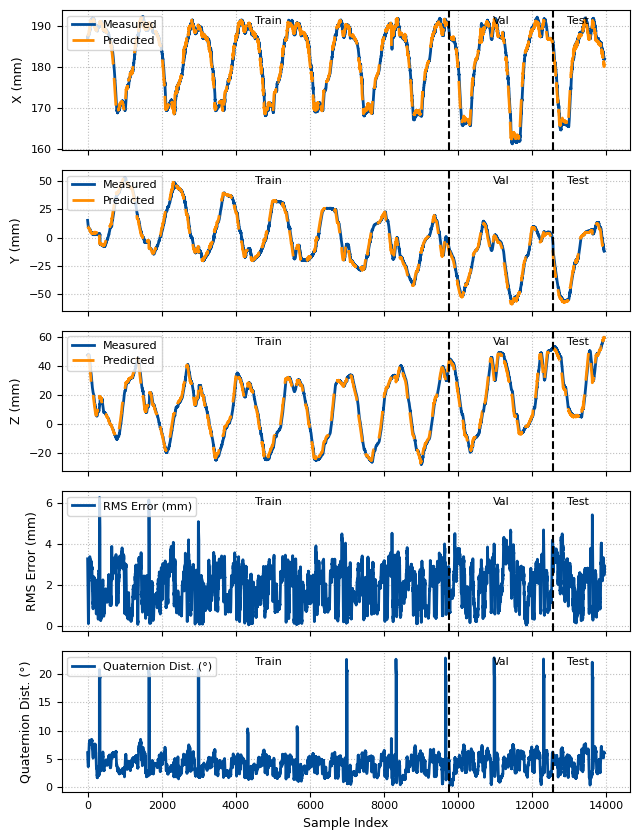

In [22]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# User‐adjustable parameters
# -----------------------------------------------------------------------------
orig_lw       = 2       # thickness of the solid (original) line
pred_lw       = 2      # thickness of the dashed (prediction) line
pred_dashes   = (10, 5)   # 10-point dash, 5-point gap
label_y_frac  = 0.1       # fraction down from top of axis for “Train/Val/Test” text
save_dpi      = 800       # DPI for high-quality export

# -----------------------------------------------------------------------------
# 1) Load data
# -----------------------------------------------------------------------------
org_pos  = sio.loadmat('TEE_Zero_org_pos_matlab.mat')
pred_pos = sio.loadmat('TEE_Zero_predict_pos_matlab.mat')
org_ori  = sio.loadmat('TEE_Zero_org_orient_matlab.mat')
pred_ori = sio.loadmat('TEE_Zero_predict_orient_matlab.mat')

# -----------------------------------------------------------------------------
# 2) Extract & scale position
# -----------------------------------------------------------------------------
x  = org_pos['x_total'].squeeze() * 1000
y  = org_pos['y_total'].squeeze() * 1000
z  = org_pos['z_total'].squeeze() * 1000
xp = pred_pos['xp_total'].squeeze() * 1000
yp = pred_pos['yp_total'].squeeze() * 1000
zp = pred_pos['zp_total'].squeeze() * 1000

# -----------------------------------------------------------------------------
# 3) Compute quaternion distance
# -----------------------------------------------------------------------------
s, o1, o2, o3 = (org_ori['s_total'].squeeze(),
                 org_ori['o1_total'].squeeze(),
                 org_ori['o2_total'].squeeze(),
                 org_ori['o3_total'].squeeze())
q_org = np.vstack([s, o1, o2, o3]).T
sp, o1p, o2p, o3p = (pred_ori['sp_total'].squeeze(),
                     pred_ori['o1p_total'].squeeze(),
                     pred_ori['o2p_total'].squeeze(),
                     pred_ori['o3p_total'].squeeze())
q_pred = np.vstack([sp, o1p, o2p, o3p]).T
q_org_norm  = q_org  / np.linalg.norm(q_org,  axis=1, keepdims=True)
q_pred_norm = q_pred / np.linalg.norm(q_pred, axis=1, keepdims=True)
dot = np.clip(np.abs(np.sum(q_org_norm * q_pred_norm, axis=1)), 0, 1)
quat_dist = np.degrees(2 * np.arccos(dot))

# -----------------------------------------------------------------------------
# 4) Compute RMS error
# -----------------------------------------------------------------------------
rms_err = np.sqrt(((x - xp)**2 + (y - yp)**2 + (z - zp)**2) / 3.0)

# -----------------------------------------------------------------------------
# 5) Sample index and split points
# -----------------------------------------------------------------------------
N = x.size
samples   = np.arange(N)
train_end = int(0.7 * N)
val_end   = int(0.9 * N)

# -----------------------------------------------------------------------------
# 6) Colors
# -----------------------------------------------------------------------------
#col_true = '#1f77b4'  # solid blue for original
col_pred = '#FF8C00'  # strong red for prediction

col_true = '#004D99'  # solid blue for original
#col_pred = '#FF8C00'  # strong red for prediction


# -----------------------------------------------------------------------------
# 7) Plot (modified for two-column paper)
# -----------------------------------------------------------------------------
plt.rc('grid', linestyle=':', color='0.75')
fig, axs = plt.subplots(5, 1, figsize=(6.5, 8.5), sharex=True)  # width x height in inches

def plot_split(ax, true, pred=None, ylabel=''):
    label_true = 'Measured' if pred is not None else ylabel
    ax.plot(samples, true,
            color=col_true, linewidth=orig_lw,
            label=label_true)
    if pred is not None:
        line, = ax.plot(samples, pred,
                        linestyle='--', color=col_pred,
                        linewidth=pred_lw, label='Predicted')
        line.set_dashes(pred_dashes)

    ax.axvline(train_end, color='k', linestyle='--')
    ax.axvline(val_end,   color='k', linestyle='--')

    ylim = ax.get_ylim()
    yloc = ylim[1] - label_y_frac * (ylim[1] - ylim[0])
    ax.text(train_end/2,           yloc, 'Train', color='k', ha='center', fontsize=8)
    ax.text((train_end+val_end)/2, yloc, 'Val',   color='k', ha='center', fontsize=8)
    ax.text((val_end+N)/2,         yloc, 'Test',  color='k', ha='center', fontsize=8)

    ax.set_ylabel(ylabel, fontsize=9)
    ax.legend(loc='upper left', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

plot_split(axs[0], x,       xp,       'X (mm)')
plot_split(axs[1], y,       yp,       'Y (mm)')
plot_split(axs[2], z,       zp,       'Z (mm)')
plot_split(axs[3], rms_err, None,     'RMS Error (mm)')
plot_split(axs[4], quat_dist, None,   'Quaternion Dist. (°)')

axs[-1].set_xlabel('Sample Index', fontsize=9)
plt.tight_layout()

# -----------------------------------------------------------------------------
# 8) Save figure at 600 ppi
# -----------------------------------------------------------------------------
fig.savefig('Zero_rotated_results.png',
            dpi=save_dpi,
            bbox_inches='tight')



In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Predict on each split ---
pred_train = model.predict([x_train_multi_1, f_train_multi_1])
pred_val   = model.predict([x_val_multi_1,   f_val_multi_1])
pred_test  = model.predict([x_test_multi_1,  f_test_multi_1])

# --- 2) Extract true vs. predicted X/Y/Z ---
def get_xyz(true_windows, preds):
    true_xyz = true_windows[:, 1, :3]  # central timestep channels 0–2
    pred_xyz = preds[:, :3]
    return true_xyz, pred_xyz

true_t, pred_t = get_xyz(x_train_multi_1, pred_train)
true_v, pred_v = get_xyz(x_val_multi_1,   pred_val)
true_s, pred_s = get_xyz(x_test_multi_1,  pred_test)

# --- 3) Compute position metrics ---
def compute_metrics(y_true, y_pred):
    y_true_flat = y_true.reshape(-1, 3)
    y_pred_flat = y_pred.reshape(-1, 3)
    return {
        'MAE':  mean_absolute_error(y_true_flat, y_pred_flat),
        'MSE':  mean_squared_error(y_true_flat, y_pred_flat),
        'RMSE': np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)),
        'R²':   r2_score(y_true_flat, y_pred_flat)
    }

pos_metrics = {
    'Train':      compute_metrics(true_t, pred_t),
    'Validation': compute_metrics(true_v, pred_v),
    'Test':       compute_metrics(true_s, pred_s),
}

# --- 4) Extract true vs. predicted quaternions and compute angular error ---
def get_quat_error(true_windows, preds):
    # extract q = [o1,o2,o3,s] from central timestep (channels 3–6)
    q_true = true_windows[:, 1, 3:7]
    q_pred = preds[:, 3:7]
    # normalize
    q_true /= np.linalg.norm(q_true, axis=1, keepdims=True)
    q_pred /= np.linalg.norm(q_pred, axis=1, keepdims=True)
    # angle error = 2 * arccos(|dot|)
    dots = np.clip(np.abs((q_true * q_pred).sum(axis=1)), 0, 1)
    angles = np.degrees(2 * np.arccos(dots))
    return angles

ang_t = get_quat_error(x_train_multi_1, pred_train)
ang_v = get_quat_error(x_val_multi_1,   pred_val)
ang_s = get_quat_error(x_test_multi_1,  pred_test)

def compute_angle_metrics(errors):
    return {
        'Mean Angle Error (deg)': np.mean(errors),
        'RMSE Angle Error (deg)': np.sqrt(np.mean(errors**2))
    }

quat_metrics = {
    'Train':      compute_angle_metrics(ang_t),
    'Validation': compute_angle_metrics(ang_v),
    'Test':       compute_angle_metrics(ang_s),
}

# --- 5) Combine into tables and display ---
df_pos  = pd.DataFrame(pos_metrics).T
df_quat = pd.DataFrame(quat_metrics).T

print("Position Metrics (X/Y/Z):")
print(df_pos.to_string(float_format="%.4f"))
print("\nOrientation Metrics (Quaternion angle error):")
print(df_quat.to_string(float_format="%.4f"))


44/44 [==============================] - 0s 7ms/step
Position Metrics (X/Y/Z):
              MAE    MSE   RMSE     R²
Train      0.0859 0.0122 0.1104 0.9856
Validation 0.1027 0.0170 0.1305 0.9840
Test       0.1066 0.0186 0.1364 0.9808

Orientation Metrics (Quaternion angle error):
            Mean Angle Error (deg)  RMSE Angle Error (deg)
Train                      10.9236                 12.9691
Validation                 10.6078                 11.7319
Test                        9.0854                  9.9086


# Representation: Positions TEE_45

In [24]:
##### STAGE 1 – PREDICTIONS for TEE_45 (including TEST set)

# 1) get your model outputs
pred_train_2 = model.predict([x_train_multi_2, f_train_multi_2])  # (N_train, …)
pred_val_2   = model.predict([x_val_multi_2,   f_val_multi_2])    # (N_val,   …)
pred_test_2  = model.predict([x_test_multi_2,  f_test_multi_2])   # (N_test,  …)

# 2) pull out the normalized+co_p-scaled x,y,z channels from each split
#    (columns 0,1,2 of the pose output)
xpt_2 = pred_train_2[:, 0];  xpv_2 = pred_val_2[:, 0];  xts_2 = pred_test_2[:, 0]
ypt_2 = pred_train_2[:, 1];  ypv_2 = pred_val_2[:, 1];  yts_2 = pred_test_2[:, 1]
zpt_2 = pred_train_2[:, 2];  zpv_2 = pred_val_2[:, 2];  zts_2 = pred_test_2[:, 2]

# 3) same for your inputs (2nd timestep, channels 0:3)
xt_2  = x_train_multi_2[:, 1, 0];  xv_2  = x_val_multi_2[:, 1, 0];  xtst_2 = x_test_multi_2[:, 1, 0]
yt_2  = x_train_multi_2[:, 1, 1];  yv_2  = x_val_multi_2[:, 1, 1];  ytst_2 = x_test_multi_2[:, 1, 1]
zt_2  = x_train_multi_2[:, 1, 2];  zv_2  = x_val_multi_2[:, 1, 2];  ztst_2 = x_test_multi_2[:, 1, 2]

# 4) concatenate train + val + test
x_norm_total  = np.concatenate([xt_2,  xv_2,  xtst_2])
y_norm_total  = np.concatenate([yt_2,  yv_2,  ytst_2])
z_norm_total  = np.concatenate([zt_2,  zv_2,  ztst_2])

xp_norm_total = np.concatenate([xpt_2, xpv_2, xts_2])
yp_norm_total = np.concatenate([ypt_2, ypv_2, yts_2])
zp_norm_total = np.concatenate([zpt_2, zpv_2, zts_2])

# 5) back-scale each channel using 45°-split stats
x_real_total  = (x_norm_total  / co_p) * pose_std_45[0] + pose_mean_45[0]
y_real_total  = (y_norm_total  / co_p) * pose_std_45[1] + pose_mean_45[1]
z_real_total  = (z_norm_total  / co_p) * pose_std_45[2] + pose_mean_45[2]

xp_real_total = (xp_norm_total / co_p) * pose_std_45[0] + pose_mean_45[0]
yp_real_total = (yp_norm_total / co_p) * pose_std_45[1] + pose_mean_45[1]
zp_real_total = (zp_norm_total / co_p) * pose_std_45[2] + pose_mean_45[2]

# Now:
#   x_real_total, y_real_total, z_real_total   → ground-truth positions (all splits)
#   xp_real_total, yp_real_total, zp_real_total → predicted positions (all splits)


44/44 [==============================] - 0s 7ms/step


In [25]:
import scipy.io as sio
TEE_45_org_pos_matlab = {"x_total": x_real_total, "y_total": y_real_total, "z_total": z_real_total, "label": "TEE_45_org_pos"}
TEE_45_predict_pos_matlab = {"xp_total": xp_real_total, "yp_total": yp_real_total, "zp_total": zp_real_total, "label": "TEE_45_Predict_pos"}
sio.savemat('TEE_45_org_pos_matlab.mat', TEE_45_org_pos_matlab)
sio.savemat('TEE_45_predict_pos_matlab.mat', TEE_45_predict_pos_matlab)

# Representation: Orientation TEE_45

In [26]:
##### STAGE 1 – PREDICTIONS for TEE_45 (including TEST set)

# 1) get your model outputs
pred_train_2 = model.predict([x_train_multi_2, f_train_multi_2])
pred_val_2   = model.predict([x_val_multi_2,   f_val_multi_2])
pred_test_2  = model.predict([x_test_multi_2,  f_test_multi_2])

# 2) extract normalized+co_p-scaled quaternion from inputs
#    (2nd timestep in each window, channels 3–6)
o1t = x_train_multi_2[:,1,3]   # qx train
o1v = x_val_multi_2[:,1,3]     # qx val
o1s = x_test_multi_2[:,1,3]    # qx test

o2t = x_train_multi_2[:,1,4]   # qy train
o2v = x_val_multi_2[:,1,4]     # qy val
o2s = x_test_multi_2[:,1,4]    # qy test

o3t = x_train_multi_2[:,1,5]   # qz train
o3v = x_val_multi_2[:,1,5]     # qz val
o3s = x_test_multi_2[:,1,5]    # qz test

st  = x_train_multi_2[:,1,6]   # qw train
sv  = x_val_multi_2[:,1,6]     # qw val
ss  = x_test_multi_2[:,1,6]    # qw test

# 3) concatenate train + val + test
o1_norm = np.concatenate([o1t, o1v, o1s])
o2_norm = np.concatenate([o2t, o2v, o2s])
o3_norm = np.concatenate([o3t, o3v, o3s])
s_norm  = np.concatenate([st,  sv,  ss ])

# 4) extract corresponding predicted channels and concatenate
o1p = np.concatenate([pred_train_2[:,3], pred_val_2[:,3], pred_test_2[:,3]])
o2p = np.concatenate([pred_train_2[:,4], pred_val_2[:,4], pred_test_2[:,4]])
o3p = np.concatenate([pred_train_2[:,5], pred_val_2[:,5], pred_test_2[:,5]])
sp_ = np.concatenate([pred_train_2[:,6], pred_val_2[:,6], pred_test_2[:,6]])

# 5) BACK-SCALING (undo co_p then z-score) using 45°-split stats
o1_real = (o1_norm / co_p) * pose_std_45[3] + pose_mean_45[3]
o2_real = (o2_norm / co_p) * pose_std_45[4] + pose_mean_45[4]
o3_real = (o3_norm / co_p) * pose_std_45[5] + pose_mean_45[5]
s_real  = ( s_norm / co_p) * pose_std_45[6] + pose_mean_45[6]

o1p_real = (o1p   / co_p) * pose_std_45[3] + pose_mean_45[3]
o2p_real = (o2p   / co_p) * pose_std_45[4] + pose_mean_45[4]
o3p_real = (o3p   / co_p) * pose_std_45[5] + pose_mean_45[5]
sp_real  = (sp_   / co_p) * pose_std_45[6] + pose_mean_45[6]

# Now:
#   o1_real,o2_real,o3_real,s_real   → ground-truth quaternions (all splits)
#   o1p_real,o2p_real,o3p_real,sp_real  → predicted quaternions (all splits)


44/44 [==============================] - 0s 7ms/step


In [27]:
TEE_45_org_orient_matlab = {"o1_total": o1_real, "o2_total": o2_real, "o3_total": o3_real, "s_total": s_real, "label": "TEE_45_org_orient"}
TEE_45_predict_orient_matlab = {"o1p_total": o1p_real, "o2p_total": o2p_real, "o3p_total": o3p_real, "sp_total": sp_real, "label": "TEE_45_Predict_orient"}
sio.savemat('TEE_45_org_orient_matlab.mat', TEE_45_org_orient_matlab)
sio.savemat('TEE_45_predict_orient_matlab.mat', TEE_45_predict_orient_matlab)

# TEE_45

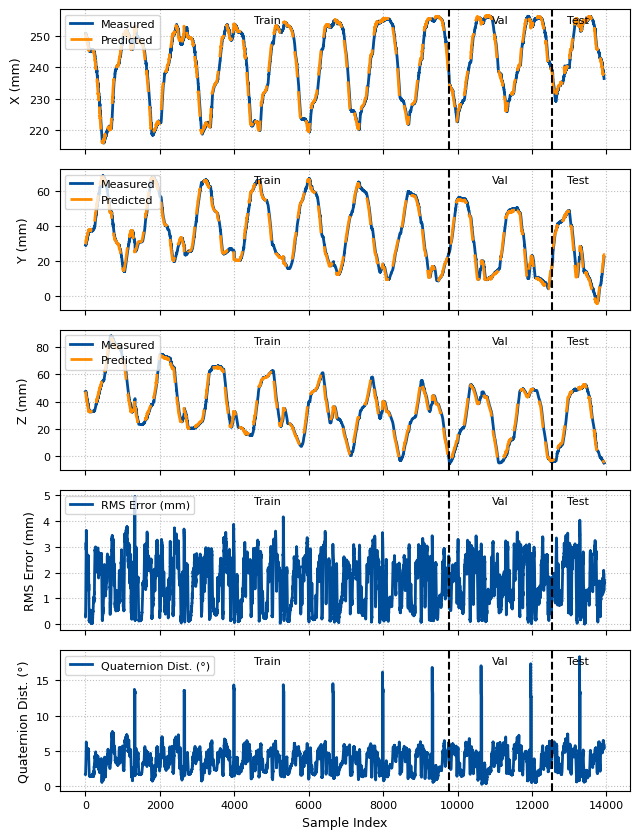

In [28]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# User‐adjustable parameters
# -----------------------------------------------------------------------------
orig_lw       = 2        # thickness of the solid (original) line
pred_lw       = 2         # thickness of the dashed (prediction) line
pred_dashes   = (10, 5)   # 10-point dash, 5-point gap
label_y_frac  = 0.1       # fraction down from top of axis for “Train/Val/Test” text
save_dpi      = 800       # DPI for high-quality export

# -----------------------------------------------------------------------------
# 1) Load data
# -----------------------------------------------------------------------------
org_pos  = sio.loadmat('TEE_45_org_pos_matlab.mat')
pred_pos = sio.loadmat('TEE_45_predict_pos_matlab.mat')
org_ori  = sio.loadmat('TEE_45_org_orient_matlab.mat')
pred_ori = sio.loadmat('TEE_45_predict_orient_matlab.mat')

# -----------------------------------------------------------------------------
# 2) Extract & scale position
# -----------------------------------------------------------------------------
x  = org_pos['x_total'].squeeze() * 1000
y  = org_pos['y_total'].squeeze() * 1000
z  = org_pos['z_total'].squeeze() * 1000
xp = pred_pos['xp_total'].squeeze() * 1000
yp = pred_pos['yp_total'].squeeze() * 1000
zp = pred_pos['zp_total'].squeeze() * 1000

# -----------------------------------------------------------------------------
# 3) Compute quaternion distance
# -----------------------------------------------------------------------------
s, o1, o2, o3 = (org_ori['s_total'].squeeze(),
                 org_ori['o1_total'].squeeze(),
                 org_ori['o2_total'].squeeze(),
                 org_ori['o3_total'].squeeze())
q_org = np.vstack([s, o1, o2, o3]).T
sp, o1p, o2p, o3p = (pred_ori['sp_total'].squeeze(),
                     pred_ori['o1p_total'].squeeze(),
                     pred_ori['o2p_total'].squeeze(),
                     pred_ori['o3p_total'].squeeze())
q_pred = np.vstack([sp, o1p, o2p, o3p]).T
q_org_norm  = q_org  / np.linalg.norm(q_org,  axis=1, keepdims=True)
q_pred_norm = q_pred / np.linalg.norm(q_pred, axis=1, keepdims=True)
dot = np.clip(np.abs(np.sum(q_org_norm * q_pred_norm, axis=1)), 0, 1)
quat_dist = np.degrees(2 * np.arccos(dot))

# -----------------------------------------------------------------------------
# 4) Compute RMS error
# -----------------------------------------------------------------------------
rms_err = np.sqrt(((x - xp)**2 + (y - yp)**2 + (z - zp)**2) / 3.0)

# -----------------------------------------------------------------------------
# 5) Sample index and split points
# -----------------------------------------------------------------------------
N = x.size
samples   = np.arange(N)
train_end = int(0.7 * N)
val_end   = int(0.9 * N)

# -----------------------------------------------------------------------------
# 6) Colors
# -----------------------------------------------------------------------------
#col_true = '#1f77b4'  # solid blue for original
col_pred = '#FF8C00'  # strong red for prediction

col_true = '#004D99'  # solid blue for original
#col_pred = '#FF8C00'  # strong red for prediction


# -----------------------------------------------------------------------------
# 7) Plot (modified for two-column paper)
# -----------------------------------------------------------------------------
plt.rc('grid', linestyle=':', color='0.75')
fig, axs = plt.subplots(5, 1, figsize=(6.5, 8.5), sharex=True)  # width x height in inches

def plot_split(ax, true, pred=None, ylabel=''):
    label_true = 'Measured' if pred is not None else ylabel
    ax.plot(samples, true,
            color=col_true, linewidth=orig_lw,
            label=label_true)
    if pred is not None:
        line, = ax.plot(samples, pred,
                        linestyle='--', color=col_pred,
                        linewidth=pred_lw, label='Predicted')
        line.set_dashes(pred_dashes)

    ax.axvline(train_end, color='k', linestyle='--')
    ax.axvline(val_end,   color='k', linestyle='--')

    ylim = ax.get_ylim()
    yloc = ylim[1] - label_y_frac * (ylim[1] - ylim[0])
    ax.text(train_end/2,           yloc, 'Train', color='k', ha='center', fontsize=8)
    ax.text((train_end+val_end)/2, yloc, 'Val',   color='k', ha='center', fontsize=8)
    ax.text((val_end+N)/2,         yloc, 'Test',  color='k', ha='center', fontsize=8)

    ax.set_ylabel(ylabel, fontsize=9)
    ax.legend(loc='upper left', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

plot_split(axs[0], x,       xp,       'X (mm)')
plot_split(axs[1], y,       yp,       'Y (mm)')
plot_split(axs[2], z,       zp,       'Z (mm)')
plot_split(axs[3], rms_err, None,     'RMS Error (mm)')
plot_split(axs[4], quat_dist, None,   'Quaternion Dist. (°)')

axs[-1].set_xlabel('Sample Index', fontsize=9)
plt.tight_layout()

# -----------------------------------------------------------------------------
# 8) Save figure at 600 ppi
# -----------------------------------------------------------------------------
fig.savefig('45_rotated_results.png',
            dpi=save_dpi,
            bbox_inches='tight')





In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Predict on each split for dataset 2 ---
pred_train = model.predict([x_train_multi_2, f_train_multi_2])
pred_val   = model.predict([x_val_multi_2,   f_val_multi_2])
pred_test  = model.predict([x_test_multi_2,  f_test_multi_2])

# --- 2) Extract true vs. predicted X/Y/Z ---
def get_xyz(true_windows, preds):
    true_xyz = true_windows[:, 1, :3]  # central timestep channels 0–2
    pred_xyz = preds[:, :3]
    return true_xyz, pred_xyz

true_t, pred_t = get_xyz(x_train_multi_2, pred_train)
true_v, pred_v = get_xyz(x_val_multi_2,   pred_val)
true_s, pred_s = get_xyz(x_test_multi_2,  pred_test)

# --- 3) Compute position metrics ---
def compute_metrics(y_true, y_pred):
    y_true_flat = y_true.reshape(-1, 3)
    y_pred_flat = y_pred.reshape(-1, 3)
    return {
        'MAE':  mean_absolute_error(y_true_flat, y_pred_flat),
        'MSE':  mean_squared_error(y_true_flat, y_pred_flat),
        'RMSE': np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)),
        'R²':   r2_score(y_true_flat, y_pred_flat)
    }

pos_metrics = {
    'Train':      compute_metrics(true_t, pred_t),
    'Validation': compute_metrics(true_v, pred_v),
    'Test':       compute_metrics(true_s, pred_s),
}

# --- 4) Extract true vs. predicted quaternions and compute angular error ---
def get_quat_error(true_windows, preds):
    # extract q = [o1,o2,o3,s] from central timestep (channels 3–6)
    q_true = true_windows[:, 1, 3:7]
    q_pred = preds[:, 3:7]
    # normalize
    q_true /= np.linalg.norm(q_true, axis=1, keepdims=True)
    q_pred /= np.linalg.norm(q_pred, axis=1, keepdims=True)
    # angle error = 2 * arccos(|dot|)
    dots = np.clip(np.abs((q_true * q_pred).sum(axis=1)), 0, 1)
    angles = np.degrees(2 * np.arccos(dots))
    return angles

ang_t = get_quat_error(x_train_multi_2, pred_train)
ang_v = get_quat_error(x_val_multi_2,   pred_val)
ang_s = get_quat_error(x_test_multi_2,  pred_test)

def compute_angle_metrics(errors):
    return {
        'Mean Angle Error (deg)': np.mean(errors),
        'RMSE Angle Error (deg)': np.sqrt(np.mean(errors**2))
    }

quat_metrics = {
    'Train':      compute_angle_metrics(ang_t),
    'Validation': compute_angle_metrics(ang_v),
    'Test':       compute_angle_metrics(ang_s),
}

# --- 5) Combine into tables and display ---
df_pos  = pd.DataFrame(pos_metrics).T
df_quat = pd.DataFrame(quat_metrics).T

print("Position Metrics (X/Y/Z):")
print(df_pos.to_string(float_format="%.4f"))
print("\nOrientation Metrics (Quaternion angle error):")
print(df_quat.to_string(float_format="%.4f"))


44/44 [==============================] - 0s 7ms/step
Position Metrics (X/Y/Z):
              MAE    MSE   RMSE     R²
Train      0.0834 0.0121 0.1099 0.9876
Validation 0.0826 0.0111 0.1055 0.9875
Test       0.0831 0.0119 0.1092 0.9849

Orientation Metrics (Quaternion angle error):
            Mean Angle Error (deg)  RMSE Angle Error (deg)
Train                      11.5483                 13.2634
Validation                 10.3340                 11.7722
Test                        8.0848                  8.7897


# Representation: Positions TEE_90

In [30]:
##### STAGE 1 – PREDICTIONS for TEE_90 (including TEST set)

# 1) get your model outputs
pred_train_3 = model.predict([x_train_multi_3, f_train_multi_3])  # (N_train, …)
pred_val_3   = model.predict([x_val_multi_3,   f_val_multi_3])    # (N_val,   …)
pred_test_3  = model.predict([x_test_multi_3,  f_test_multi_3])   # (N_test,  …)

# 2) pull out the normalized+co_p-scaled x,y,z channels from each split
xpt_3 = pred_train_3[:, 0];  xpv_3 = pred_val_3[:, 0];  xts_3 = pred_test_3[:, 0]
ypt_3 = pred_train_3[:, 1];  ypv_3 = pred_val_3[:, 1];  yts_3 = pred_test_3[:, 1]
zpt_3 = pred_train_3[:, 2];  zpv_3 = pred_val_3[:, 2];  zts_3 = pred_test_3[:, 2]

# 3) same for your inputs (2nd timestep in each window, channels 0:3)
xt_3  = x_train_multi_3[:, 1, 0];  xv_3  = x_val_multi_3[:, 1, 0];  xtst_3 = x_test_multi_3[:, 1, 0]
yt_3  = x_train_multi_3[:, 1, 1];  yv_3  = x_val_multi_3[:, 1, 1];  ytst_3 = x_test_multi_3[:, 1, 1]
zt_3  = x_train_multi_3[:, 1, 2];  zv_3  = x_val_multi_3[:, 1, 2];  ztst_3 = x_test_multi_3[:, 1, 2]

# 4) concatenate train + val + test
x_norm_total  = np.concatenate([xt_3,  xv_3,  xtst_3])
y_norm_total  = np.concatenate([yt_3,  yv_3,  ytst_3])
z_norm_total  = np.concatenate([zt_3,  zv_3,  ztst_3])

xp_norm_total = np.concatenate([xpt_3, xpv_3, xts_3])
yp_norm_total = np.concatenate([ypt_3, ypv_3, yts_3])
zp_norm_total = np.concatenate([zpt_3, zpv_3, zts_3])

# 5) back-scale each channel using 90°-split stats
x_real_total  = (x_norm_total  / co_p) * pose_std_90[0] + pose_mean_90[0]
y_real_total  = (y_norm_total  / co_p) * pose_std_90[1] + pose_mean_90[1]
z_real_total  = (z_norm_total  / co_p) * pose_std_90[2] + pose_mean_90[2]

xp_real_total = (xp_norm_total / co_p) * pose_std_90[0] + pose_mean_90[0]
yp_real_total = (yp_norm_total / co_p) * pose_std_90[1] + pose_mean_90[1]
zp_real_total = (zp_norm_total / co_p) * pose_std_90[2] + pose_mean_90[2]

# Now x_real_total, y_real_total, z_real_total are ground-truth
# and xp_real_total, yp_real_total, zp_real_total are predicted positions


44/44 [==============================] - 0s 7ms/step


In [31]:

TEE_90_org_pos_matlab = {"x_total": x_real_total, "y_total": y_real_total, "z_total": z_real_total, "label": "TEE_90_org_pos"}
TEE_90_predict_pos_matlab = {"xp_total": xp_real_total, "yp_total": yp_real_total, "zp_total": zp_real_total, "label": "TEE_90_Predict_pos"}
sio.savemat('TEE_90_org_pos_matlab.mat', TEE_90_org_pos_matlab)
sio.savemat('TEE_90_predict_pos_matlab.mat', TEE_90_predict_pos_matlab)

# Representation: Oriantation TEE_90

In [32]:
##### STAGE 1 – PREDICTIONS for TEE_90 (including TEST set)

# 1) get your model outputs
pred_train_3 = model.predict([x_train_multi_3, f_train_multi_3])
pred_val_3   = model.predict([x_val_multi_3,   f_val_multi_3])
pred_test_3  = model.predict([x_test_multi_3,  f_test_multi_3])

# 2) extract normalized+co_p-scaled quaternion from inputs
#    (2nd timestep in each window, channels 3–6)
o1t = x_train_multi_3[:,1,3]   # qx train
o1v = x_val_multi_3[:,1,3]     # qx val
o1s = x_test_multi_3[:,1,3]    # qx test

o2t = x_train_multi_3[:,1,4]   # qy train
o2v = x_val_multi_3[:,1,4]     # qy val
o2s = x_test_multi_3[:,1,4]    # qy test

o3t = x_train_multi_3[:,1,5]   # qz train
o3v = x_val_multi_3[:,1,5]     # qz val
o3s = x_test_multi_3[:,1,5]    # qz test

st  = x_train_multi_3[:,1,6]   # qw train
sv  = x_val_multi_3[:,1,6]     # qw val
ss  = x_test_multi_3[:,1,6]    # qw test

# 3) concatenate train + val + test
o1_norm = np.concatenate([o1t, o1v, o1s])
o2_norm = np.concatenate([o2t, o2v, o2s])
o3_norm = np.concatenate([o3t, o3v, o3s])
s_norm  = np.concatenate([st,  sv,  ss ])

# 4) extract corresponding predicted channels and concatenate
o1p = np.concatenate([pred_train_3[:,3], pred_val_3[:,3], pred_test_3[:,3]])
o2p = np.concatenate([pred_train_3[:,4], pred_val_3[:,4], pred_test_3[:,4]])
o3p = np.concatenate([pred_train_3[:,5], pred_val_3[:,5], pred_test_3[:,5]])
sp_ = np.concatenate([pred_train_3[:,6], pred_val_3[:,6], pred_test_3[:,6]])

# 5) BACK-SCALING (undo co_p then z-score) using 90°-split stats
o1_real = (o1_norm / co_p) * pose_std_90[3] + pose_mean_90[3]
o2_real = (o2_norm / co_p) * pose_std_90[4] + pose_mean_90[4]
o3_real = (o3_norm / co_p) * pose_std_90[5] + pose_mean_90[5]
s_real  = ( s_norm / co_p) * pose_std_90[6] + pose_mean_90[6]

o1p_real = (o1p   / co_p) * pose_std_90[3] + pose_mean_90[3]
o2p_real = (o2p   / co_p) * pose_std_90[4] + pose_mean_90[4]
o3p_real = (o3p   / co_p) * pose_std_90[5] + pose_mean_90[5]
sp_real  = (sp_   / co_p) * pose_std_90[6] + pose_mean_90[6]

# Now:
#   o1_real, o2_real, o3_real, s_real   → ground-truth quaternions (all splits)
#   o1p_real, o2p_real, o3p_real, sp_real → predicted quaternions (all splits)


44/44 [==============================] - 0s 6ms/step


In [33]:

TEE_90_org_orient_matlab = {"o1_total": o1_real, "o2_total": o2_real, "o3_total": o3_real, "s_total": s_real, "label": "TEE_90_org_orient"}
TEE_90_predict_orient_matlab = {"o1p_total": o1p_real, "o2p_total": o2p_real, "o3p_total": o3p_real, "sp_total": sp_real, "label": "TEE_90_Predict_orient"}
sio.savemat('TEE_90_org_orient_matlab.mat', TEE_90_org_orient_matlab)
sio.savemat('TEE_90_predict_orient_matlab.mat', TEE_90_predict_orient_matlab)

# TEE_90_Visualization

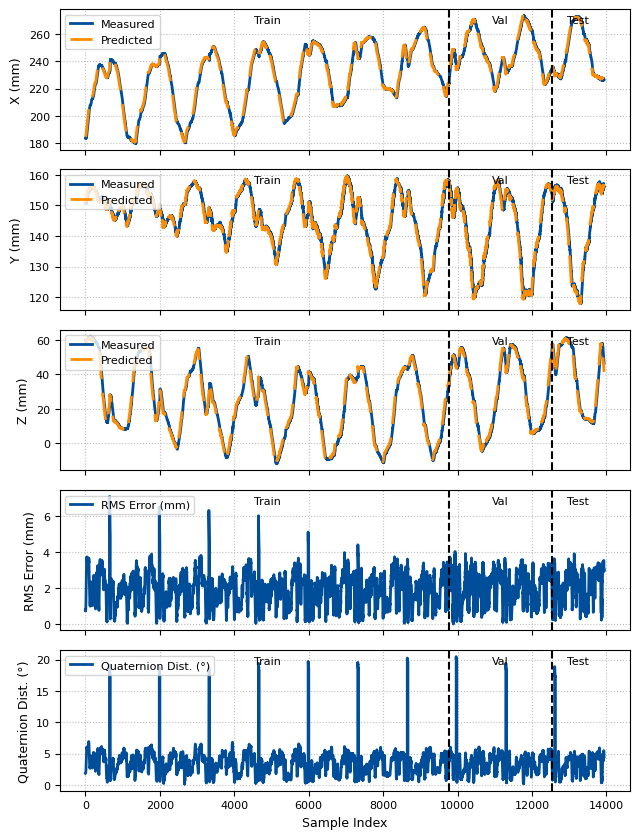

In [34]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# User‐adjustable parameters
# -----------------------------------------------------------------------------
orig_lw       = 2         # thickness of the solid (original) line
pred_lw       = 2         # thickness of the dashed (prediction) line
pred_dashes   = (10, 5)   # 10-point dash, 5-point gap
label_y_frac  = 0.1       # fraction down from top of axis for “Train/Val/Test” text
save_dpi      = 800       # DPI for high-quality export

# -----------------------------------------------------------------------------
# 1) Load data
# -----------------------------------------------------------------------------
org_pos  = sio.loadmat('TEE_90_org_pos_matlab.mat')
pred_pos = sio.loadmat('TEE_90_predict_pos_matlab.mat')
org_ori  = sio.loadmat('TEE_90_org_orient_matlab.mat')
pred_ori = sio.loadmat('TEE_90_predict_orient_matlab.mat')

# -----------------------------------------------------------------------------
# 2) Extract & scale position
# -----------------------------------------------------------------------------
x  = org_pos['x_total'].squeeze() * 1000
y  = org_pos['y_total'].squeeze() * 1000
z  = org_pos['z_total'].squeeze() * 1000
xp = pred_pos['xp_total'].squeeze() * 1000
yp = pred_pos['yp_total'].squeeze() * 1000
zp = pred_pos['zp_total'].squeeze() * 1000

# -----------------------------------------------------------------------------
# 3) Compute quaternion distance
# -----------------------------------------------------------------------------
s, o1, o2, o3 = (org_ori['s_total'].squeeze(),
                 org_ori['o1_total'].squeeze(),
                 org_ori['o2_total'].squeeze(),
                 org_ori['o3_total'].squeeze())
q_org = np.vstack([s, o1, o2, o3]).T
sp, o1p, o2p, o3p = (pred_ori['sp_total'].squeeze(),
                     pred_ori['o1p_total'].squeeze(),
                     pred_ori['o2p_total'].squeeze(),
                     pred_ori['o3p_total'].squeeze())
q_pred = np.vstack([sp, o1p, o2p, o3p]).T
q_org_norm  = q_org  / np.linalg.norm(q_org,  axis=1, keepdims=True)
q_pred_norm = q_pred / np.linalg.norm(q_pred, axis=1, keepdims=True)
dot = np.clip(np.abs(np.sum(q_org_norm * q_pred_norm, axis=1)), 0, 1)
quat_dist = np.degrees(2 * np.arccos(dot))

# -----------------------------------------------------------------------------
# 4) Compute RMS error
# -----------------------------------------------------------------------------
rms_err = np.sqrt(((x - xp)**2 + (y - yp)**2 + (z - zp)**2) / 3.0)

# -----------------------------------------------------------------------------
# 5) Sample index and split points
# -----------------------------------------------------------------------------
N = x.size
samples   = np.arange(N)
train_end = int(0.7 * N)
val_end   = int(0.9 * N)

# -----------------------------------------------------------------------------
# 6) Colors
# -----------------------------------------------------------------------------
#col_true = '#1f77b4'  # solid blue for original
col_pred = '#FF8C00'  # strong red for prediction

col_true = '#004D99'  # solid blue for original
#col_pred = '#FF8C00'  # strong red for prediction


# -----------------------------------------------------------------------------
# 7) Plot (modified for two-column paper)
# -----------------------------------------------------------------------------
plt.rc('grid', linestyle=':', color='0.75')
fig, axs = plt.subplots(5, 1, figsize=(6.5, 8.5), sharex=True)  # width x height in inches

def plot_split(ax, true, pred=None, ylabel=''):
    label_true = 'Measured' if pred is not None else ylabel
    ax.plot(samples, true,
            color=col_true, linewidth=orig_lw,
            label=label_true)
    if pred is not None:
        line, = ax.plot(samples, pred,
                        linestyle='--', color=col_pred,
                        linewidth=pred_lw, label='Predicted')
        line.set_dashes(pred_dashes)

    ax.axvline(train_end, color='k', linestyle='--')
    ax.axvline(val_end,   color='k', linestyle='--')

    ylim = ax.get_ylim()
    yloc = ylim[1] - label_y_frac * (ylim[1] - ylim[0])
    ax.text(train_end/2,           yloc, 'Train', color='k', ha='center', fontsize=8)
    ax.text((train_end+val_end)/2, yloc, 'Val',   color='k', ha='center', fontsize=8)
    ax.text((val_end+N)/2,         yloc, 'Test',  color='k', ha='center', fontsize=8)

    ax.set_ylabel(ylabel, fontsize=9)
    ax.legend(loc='upper left', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

plot_split(axs[0], x,       xp,       'X (mm)')
plot_split(axs[1], y,       yp,       'Y (mm)')
plot_split(axs[2], z,       zp,       'Z (mm)')
plot_split(axs[3], rms_err, None,     'RMS Error (mm)')
plot_split(axs[4], quat_dist, None,   'Quaternion Dist. (°)')

axs[-1].set_xlabel('Sample Index', fontsize=9)
plt.tight_layout()

# -----------------------------------------------------------------------------
# 8) Save figure at 600 ppi
# -----------------------------------------------------------------------------
fig.savefig('90_rotated_results.png',
            dpi=save_dpi,
            bbox_inches='tight')


In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Predict on each split for dataset 2 ---
pred_train = model.predict([x_train_multi_3, f_train_multi_3])
pred_val   = model.predict([x_val_multi_3,   f_val_multi_3])
pred_test  = model.predict([x_test_multi_3,  f_test_multi_3])

# --- 2) Extract true vs. predicted X/Y/Z ---
def get_xyz(true_windows, preds):
    true_xyz = true_windows[:, 1, :3]  # central timestep channels 0–2
    pred_xyz = preds[:, :3]
    return true_xyz, pred_xyz

true_t, pred_t = get_xyz(x_train_multi_3, pred_train)
true_v, pred_v = get_xyz(x_val_multi_3,   pred_val)
true_s, pred_s = get_xyz(x_test_multi_3,  pred_test)

# --- 3) Compute position metrics ---
def compute_metrics(y_true, y_pred):
    y_true_flat = y_true.reshape(-1, 3)
    y_pred_flat = y_pred.reshape(-1, 3)
    return {
        'MAE':  mean_absolute_error(y_true_flat, y_pred_flat),
        'MSE':  mean_squared_error(y_true_flat, y_pred_flat),
        'RMSE': np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)),
        'R²':   r2_score(y_true_flat, y_pred_flat)
    }

pos_metrics = {
    'Train':      compute_metrics(true_t, pred_t),
    'Validation': compute_metrics(true_v, pred_v),
    'Test':       compute_metrics(true_s, pred_s),
}

# --- 4) Extract true vs. predicted quaternions and compute angular error ---
def get_quat_error(true_windows, preds):
    # extract q = [o1,o2,o3,s] from central timestep (channels 3–6)
    q_true = true_windows[:, 1, 3:7]
    q_pred = preds[:, 3:7]
    # normalize
    q_true /= np.linalg.norm(q_true, axis=1, keepdims=True)
    q_pred /= np.linalg.norm(q_pred, axis=1, keepdims=True)
    # angle error = 2 * arccos(|dot|)
    dots = np.clip(np.abs((q_true * q_pred).sum(axis=1)), 0, 1)
    angles = np.degrees(2 * np.arccos(dots))
    return angles

ang_t = get_quat_error(x_train_multi_3, pred_train)
ang_v = get_quat_error(x_val_multi_3,   pred_val)
ang_s = get_quat_error(x_test_multi_3,  pred_test)

def compute_angle_metrics(errors):
    return {
        'Mean Angle Error (deg)': np.mean(errors),
        'RMSE Angle Error (deg)': np.sqrt(np.mean(errors**2))
    }

quat_metrics = {
    'Train':      compute_angle_metrics(ang_t),
    'Validation': compute_angle_metrics(ang_v),
    'Test':       compute_angle_metrics(ang_s),
}

# --- 5) Combine into tables and display ---
df_pos  = pd.DataFrame(pos_metrics).T
df_quat = pd.DataFrame(quat_metrics).T

print("Position Metrics (X/Y/Z):")
print(df_pos.to_string(float_format="%.4f"))
print("\nOrientation Metrics (Quaternion angle error):")
print(df_quat.to_string(float_format="%.4f"))


44/44 [==============================] - 0s 7ms/step
Position Metrics (X/Y/Z):
              MAE    MSE   RMSE     R²
Train      0.0932 0.0137 0.1170 0.9838
Validation 0.1095 0.0182 0.1350 0.9808
Test       0.1053 0.0194 0.1392 0.9811

Orientation Metrics (Quaternion angle error):
            Mean Angle Error (deg)  RMSE Angle Error (deg)
Train                       9.5209                 11.6612
Validation                  7.4723                  8.4800
Test                        5.7931                  6.6765


In [36]:
import plotly.graph_objects as go
import webbrowser
import tempfile
import os

# -- your data arrays --
# x_total, y_total, z_total   # original (N,)
# xp_total, yp_total, zp_total  # predicted (N,)

fig = go.Figure()

# original points
fig.add_trace(go.Scatter3d(
    x=x_real_total*1000, y=y_real_total*1000, z=z_real_total*1000,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original'
))

# predicted points
fig.add_trace(go.Scatter3d(
    x=xp_real_total*1000, y=yp_real_total*1000, z=zp_real_total*1000,
    mode='markers',
    marker=dict(size=3, color='red'),
    name='Predicted'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# write to a temp HTML file and open it
tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.html')
fig.write_html(tmp.name, auto_open=False)
webbrowser.open('file://' + os.path.realpath(tmp.name))


True